### Political Data Extension

In this notebook, I extend analyses in the "extra_figures" notebook to account for CEO and employee political orientations. Organizational research has shown that CEOs and companies themselves tend to have different political orientations that may inform their strategic decisions. For example, companies with more liberal CEOs and a more liberal slant among their employees tend to engage in more corporate social responsibility measures than their conservative peers (Chin et al., 2013 ASQ; Gupta et al., 2017 SMJ). companies with more conservative boards of directors tend to pay their companies' CEOs more and tie CEO compensation more closely to recent company performance (Gupta and Wowack, 2017 ASQ). 

To I pull down data on CEO and employee political contributions from the [Federal Election Commission website](https://www.fec.gov/data/browse-data/?tab=bulk-data) for individuals working for the companies in my dataset. 



In [1]:
import sys
assert sys.version_info >= (3, 5)

import zipfile
from io import BytesIO
import pandas as pd
import numpy as np
import urllib
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time
import shutil
import os
import re
import math

import nltk
from wordcloud import WordCloud
from textblob import TextBlob

# Import Matplotlib and Seaborn
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import seaborn as sns

#Import helpful user-defined functions for directories in nb_functions.py
from nb_functions import set_project_root, change_dir

try:
    PROJECT_ROOT
except:
    PROJECT_ROOT = set_project_root()

In [2]:
# Create DF of candidates from 2012-2020 election cycles

cand_urls = ['https://www.fec.gov/files/bulk-downloads/2020/cn20.zip', 
        'https://www.fec.gov/files/bulk-downloads/2018/cn18.zip', 
        'https://www.fec.gov/files/bulk-downloads/2016/cn16.zip', 
        'https://www.fec.gov/files/bulk-downloads/2014/cn14.zip', 
        'https://www.fec.gov/files/bulk-downloads/2012/cn12.zip',
       ]

cmte_urls = ['https://www.fec.gov/files/bulk-downloads/2020/cm20.zip', 
             'https://www.fec.gov/files/bulk-downloads/2018/cm18.zip', 
             'https://www.fec.gov/files/bulk-downloads/2016/cm16.zip', 
             'https://www.fec.gov/files/bulk-downloads/2014/cm14.zip', 
             'https://www.fec.gov/files/bulk-downloads/2012/cm12.zip'
             ]

cand_col_names = ['candidate_id','name','party','election_year', 'state','office', 'district', 'incumbent',
             'status', 'committee_id', 'mail_st1', 'mail_st2', 'mail_city', 'mail_state', 
             'mail_zip'
            ]

cmte_col_names = ['committee_id', 'name', 'treas_name', 'mail_st1', 'mail_st2', 'mail_city', 'mail_state', 
                  'mail_zip', 'designation', 'type', 'party', 'filing_freq', 'interest_group', 
                  'connected_org', 'candidate_id'
                 ]

cand_df = pd.DataFrame(columns=cand_col_names)
cmte_df = pd.DataFrame(columns=cmte_col_names)


def create_dataframe(urls, file_name, col_names, df_arg):
    for i in range(len(urls)):
        z = urllib.request.urlopen(urls[i])
        print(f'Opened {urls[i]} file')
        myzip = zipfile.ZipFile(BytesIO(z.read())).extract(file_name)
        df_temp = pd.read_csv(myzip, delimiter = "|", names=col_names)
        df_arg = pd.concat([df_arg, df_temp])
    df_arg = df_arg.drop_duplicates()
    return df_arg

In [3]:
# Create DF of candidates from 2012-2020 election cycles
cand_df = create_dataframe(cand_urls, 'cn.txt', cand_col_names, cand_df)
cand_df.head()

Opened https://www.fec.gov/files/bulk-downloads/2020/cn20.zip file
Opened https://www.fec.gov/files/bulk-downloads/2018/cn18.zip file
Opened https://www.fec.gov/files/bulk-downloads/2016/cn16.zip file
Opened https://www.fec.gov/files/bulk-downloads/2014/cn14.zip file
Opened https://www.fec.gov/files/bulk-downloads/2012/cn12.zip file


,candidate_id,name,party,election_year,state,office,district,incumbent,status,committee_id,mail_st1,mail_st2,mail_city,mail_state,mail_zip
0,H0AK00105,"LAMB, THOMAS",NNE,2020,AK,H,0.0,C,N,C00607515,1861 W LAKE LUCILLE DR,NaN,WASILLA,AK,99654.0
1,H0AK00113,"TUGATUK, RAY SEAN",DEM,2020,AK,H,0.0,C,N,NaN,PO BOX 172,NaN,MANAKOTAK,AK,99628.0
2,H0AK01046,"CATALANO, THOMAS",OTH,2020,AK,H,0.0,C,N,NaN,188 WEST NORTHERN LIGHTS BOULEVARD,NaN,ANCHORAGE,AK,99503.0
3,H0AL01055,"CARL, JERRY LEE, JR",REP,2020,AL,H,1.0,O,C,C00697789,PO BOX 852138,NaN,MOBILE,AL,36685.0
4,H0AL01063,"LAMBERT, DOUGLAS WESTLEY III",REP,2020,AL,H,1.0,O,C,C00701557,7194 STILLWATER BLVD,NaN,SPANISH FORT,AL,36527.0


In [4]:
# Create DF of committees from 2012-2020 election cycles
cmte_df = create_dataframe(cmte_urls, 'cm.txt', cmte_col_names, cmte_df)
cmte_df.head()

Opened https://www.fec.gov/files/bulk-downloads/2020/cm20.zip file
Opened https://www.fec.gov/files/bulk-downloads/2018/cm18.zip file
Opened https://www.fec.gov/files/bulk-downloads/2016/cm16.zip file
Opened https://www.fec.gov/files/bulk-downloads/2014/cm14.zip file
Opened https://www.fec.gov/files/bulk-downloads/2012/cm12.zip file


,committee_id,name,treas_name,mail_st1,mail_st2,mail_city,mail_state,mail_zip,designation,type,party,filing_freq,interest_group,connected_org,candidate_id
0,C00000059,HALLMARK CARDS PAC,SARAH MOE,2501 MCGEE,MD #500,KANSAS CITY,MO,64108,U,Q,UNK,M,C,NaN,NaN
1,C00000422,AMERICAN MEDICAL ASSOCIATION POLITICAL ACTION ...,"WALKER, KEVIN MR.","25 MASSACHUSETTS AVE, NW",SUITE 600,WASHINGTON,DC,200017400,B,Q,NaN,M,M,DELAWARE MEDICAL PAC,NaN
2,C00000489,D R I V E POLITICAL FUND CHAPTER 886,JERRY SIMS JR,3528 W RENO,NaN,OKLAHOMA CITY,OK,73107,U,N,NaN,Q,L,NaN,NaN
3,C00000547,KANSAS MEDICAL SOCIETY POLITICAL ACTION COMMITTEE,JERRY SLAUGHTER,623 SW 10TH AVE,NaN,TOPEKA,KS,666121627,U,Q,UNK,Q,M,KANSAS MEDICAL SOCIETY,NaN
4,C00000638,INDIANA STATE MEDICAL ASSOCIATION POLITICAL AC...,"ACHENBACH, GRANT MR.","322 CANAL WALK, CANAL LEVEL",NaN,INDIANAPOLIS,IN,46202,U,Q,NaN,T,M,NaN,NaN


In [5]:
cmte_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69568 entries, 0 to 14454
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   committee_id    69568 non-null  object
 1   name            69554 non-null  object
 2   treas_name      65699 non-null  object
 3   mail_st1        69504 non-null  object
 4   mail_st2        13299 non-null  object
 5   mail_city       69525 non-null  object
 6   mail_state      69530 non-null  object
 7   mail_zip        69485 non-null  object
 8   designation     69521 non-null  object
 9   type            69548 non-null  object
 10  party           27394 non-null  object
 11  filing_freq     69568 non-null  object
 12  interest_group  12835 non-null  object
 13  connected_org   25365 non-null  object
 14  candidate_id    26379 non-null  object
dtypes: object(15)
memory usage: 8.5+ MB


In [6]:
cand_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26846 entries, 0 to 5627
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   candidate_id   26846 non-null  object 
 1   name           26846 non-null  object 
 2   party          26806 non-null  object 
 3   election_year  26846 non-null  object 
 4   state          26846 non-null  object 
 5   office         26846 non-null  object 
 6   district       26809 non-null  float64
 7   incumbent      25761 non-null  object 
 8   status         26840 non-null  object 
 9   committee_id   20726 non-null  object 
 10  mail_st1       26355 non-null  object 
 11  mail_st2       1981 non-null   object 
 12  mail_city      26822 non-null  object 
 13  mail_state     26372 non-null  object 
 14  mail_zip       26336 non-null  float64
dtypes: float64(2), object(13)
memory usage: 3.3+ MB


In [7]:
# Create list of companies
# Start chrome driver
# Navigate to the FEC page of individual contributions
    # Select years for election cycles 2012-2020
    # Set $200 contribution minimum

In [8]:
# Create list of companies, CEOs. 
# Create objects for URLs and directory locations needed for web crawling
    
    # Get company names from accounts.py in src folder
change_dir(PROJECT_ROOT, '/data')
companies_df = pd.read_csv("common_company_names.csv")
company_list = list(companies_df['common_name'])
change_dir(PROJECT_ROOT, '/notebooks')

    # Hard code CEO names since account name != person name in accounts.py
ceo_dict = {"Sundar Pichai": "ALPHABET INC", "Jeff Bezos": "AMAZON.COM INC", "Tim Cook": "APPLE INC",
        "Charles Robbins": "CISCO SYSTEMS INC", "Lawrence Merlo": "CVS HEALTH CORP", "Michael Dell": "DELL TECHNOLOGIES INC",
        "Robert Iger": "DISNEY (WALT) CO", "Jim Fitterling": "DOW INC",
        "Mary Barra": "GENERAL MOTORS CO",
        "Marvin Ellison": "LOWE'S COS INC",
        "Satya Nadella": "MICROSOFT CORP", "Ramon Laguarta": "PEPSICO INC", "Albert Bourla": "PFIZER INC",
        "Hans Vestberg": "VERIZON COMMUNICATIONS INC"
        }


      
New Working Directory: ~/data
      
New Working Directory: ~/notebooks


In [9]:
# Note that unique queries have unique URLs, so can navigate via adding company/CEO names into URLs

source = '/Users/pjrooney/Downloads'
destination = PROJECT_ROOT + '/data/temp_data'
chrome_driver_location = '/Users/pjrooney/PythonProjects/chromedriver' # Download chromedriver and change to your dir 

def chunk_maker(lst, n):
    for i in range(0, len(lst), n):
        lst_gen = lst[i:i + n]
        lst_gen = ["&contributor_employer=" + s for s in lst_gen]
        yield lst_gen

In [10]:
def download_company_data(employers_url_gen, n_iter):    
    for n in range(n_iter):
        employer_key = next(employers_url_gen)
        employer = employer_key[-1].replace("&contributor_employer=", "")
        employer_key = "".join(employer_key)
        company_url_base = ("https://www.fec.gov/data/receipts/individual-contributions/?"
                    + employer_key + "&two_year_transaction_period=2020"
                    "&two_year_transaction_period=2018&two_year_transaction_period=2016"
                    "&two_year_transaction_period=2014&two_year_transaction_period=2012&min_amount=200"
                   )
        driver.get(company_url_base)
        print(f"Getting data for employees through {employer}")
        time.sleep(900)
        export_button = driver.find_element_by_class_name("data-container__export")
        export_button.click()
        print(f"...Exporting data")
        time.sleep(900)
        download_button = driver.find_element_by_class_name("download__item")
        download_button.click()
        print(f"...Downloading data")
        x_download_button = driver.find_element_by_xpath("//button[@class='js-close button--cancel download__cancel']")
        x_download_button.click()
        time.sleep(60)
        print(f"...Moving .csv")
        for filename in os.listdir(source):
            root, ext = os.path.splitext(filename)
            if root.startswith('schedule_a') and ext == '.csv':
                file = filename
        source_file_path = os.path.join(source + '/' + file)
        dest_file_path = os.path.join(destination + '/' + file)
        os.makedirs(os.path.dirname(dest_file_path), exist_ok=True)
        shutil.move(source_file_path, dest_file_path)
        os.chdir(destination)
        time.sleep(60)
        print(f"...Renaming .csv")
        num_file = n+1
        num_str = str(num_file)
        os.rename(file, 'company_data_' + num_str + '.csv')


In [11]:
# Create chunks of 10 company names per search (site limit), import .csv files to project folder

# chunked_list_gen = chunk_maker(company_list, 10)
# num_chunks = math.ceil(len(company_list) / 10)

# driver = webdriver.Chrome(chrome_driver_location)
# download_company_data(chunked_list_gen, num_chunks)

In [12]:
# keep committee_id, committee_name, report_year, report_type, contributor_name, 
# contributor_street_1, contributor_employer, contributor_occupation, contribution_receipt_date, 
# contribution_receipt_amount, contributor_aggregate_ytd, link_id, two_year_transaction_period,

change_dir(PROJECT_ROOT, "/data/temp_data")

import glob

file_path = os.getcwd()
all_files = glob.glob(file_path + '/*.csv')

df_list = []

for file in all_files:
    df = pd.read_csv(file)
    df = df[['committee_id', 'committee_name', 'report_year', 'report_type', 'contributor_name',
               'contributor_street_1', 'contributor_employer', 'contributor_occupation', 
               'contribution_receipt_date', 'contribution_receipt_amount', 
               'contributor_aggregate_ytd', 'link_id', 'two_year_transaction_period']]
    df_list.append(df)

indiv_df = pd.concat(df_list, axis=0, ignore_index=True)  

      
New Working Directory: ~/data/temp_data


/Users/pjrooney/Dropbox/Rotman/Research/_Dissertation/PoliticalStancesAndStrategy/5_Data/4_F100Tweets/Political Stance Tweets/.venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (37,50,51,52,53,54,57,61) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/Users/pjrooney/Dropbox/Rotman/Research/_Dissertation/PoliticalStancesAndStrategy/5_Data/4_F100Tweets/Political Stance Tweets/.venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (25,37,38,39,40,44,45,46,47,52,56,57) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/Users/pjrooney/Dropbox/Rotman/Research/_Dissertation/PoliticalStancesAndStrategy/5_Data/4_F100Tweets/Political Stance Tweets/.venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Col

In [13]:
indiv_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 641523 entries, 0 to 641522
Data columns (total 13 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   committee_id                 641523 non-null  object 
 1   committee_name               641523 non-null  object 
 2   report_year                  641523 non-null  int64  
 3   report_type                  630162 non-null  object 
 4   contributor_name             641508 non-null  object 
 5   contributor_street_1         641333 non-null  object 
 6   contributor_employer         641523 non-null  object 
 7   contributor_occupation       640553 non-null  object 
 8   contribution_receipt_date    641506 non-null  object 
 9   contribution_receipt_amount  641523 non-null  float64
 10  contributor_aggregate_ytd    641503 non-null  float64
 11  link_id                      641523 non-null  int64  
 12  two_year_transaction_period  641523 non-null  int64  
dtyp

<br><br>
The individual-entered employer data for this dataset is quite messy, with many different
entries and misspellings for individual companies. 

Given the very large size of this data (600,000+ entries), I will simplify the cleaning problem
using the following technique below. This will inevitably cause some data loss. The main goal of this cleaning is to assign political orientations to firms. It is reasonable to assume that a person's tendency to use less common spellings and misspellings of their employer is not highly correlated with individual political orientation. After applying the cleaning algorithm below, I anticipate that I will have a strong sense of organization political orientation.

1. Match company list to the list of individual contributors' employers to create an initial "match_var" boolean feature (This will mark any obvious mistake from the FEC search function as "false").

2. Make sure abbreviations (e.g., ADM) are not counted in substrings within words (e.g., "Federal Aviation Administration"). I'll add a space character after these elements to eliminate them appearing as a substring in other employers that aren't in our sample.

3. Using value counts, examine the top 200 most-occurring names, remove obvious mistakes, and check that all of the companies provided appear at least once in this series. If not, increase bandwidth by 100 most-occurring names until at least 80% of company list appears in the most-occurring name series. Add the (likely small) number of missing companies to the most-occurring names that don't already have an alternative version of the name in the most-occurring names list.

4. Examine new list of companies and individually clean any mistakes. Apply these names as a new company list and complete the same step in 1, but with exact match. 

5. Use the Levenshtein distance to determine similar names (and misspellings). Limit the allowable distance to 5 changed characters. Change all other instances of match_var to false and drop false instances.
<br><br>

In [14]:
# 1. Clean Employer Data
    # Clean company list for regex match
company_list = [x.upper() for x in company_list]
company_list = [x.replace('+', '&') for x in company_list]
company_list_orig = company_list.copy()

# 2. Remove companies that are substrings of many companies
set_to_remove = ('ADM', 'CITI', 'CHARTER', 'DOW', 'DELTA', 'FORD', 'INTEL', 'SIERRA')
company_list = [x for x in company_list if x not in set_to_remove]

# Add back companies with improved substring formatting
list_to_extend = ["COCA-COLA", "JOHNSON & JOHNSON", "PROCTER & GAMBLE", "AT & T", "ADM ", "CITI ", "CHARTER ", "DOW ", "DELTA ", "INTEL ", "FORD "]
company_list.extend(list_to_extend)

# See if employer contains any element of company_list

pattern = '|'.join(company_list)
indiv_df['match_var'] = indiv_df['contributor_employer'].str.contains(pattern, regex=True)

In [15]:
# 3. Take the top 300 matches from value counts, clean individual mistakes
alg_lst = indiv_df['contributor_employer'][indiv_df['match_var']==True].value_counts().index.tolist()[:300]
# alg_lst #<- Uncomment to manually look through entire list

In [16]:
alg_lst_set_to_remove = ['COMCAST (CC) OF WILLOW GROVE', 'HENRY FORD HEALTH SYSTEM', 
                         'HENRY FORD HOSPITAL', 'PORTLAND GENERAL ELECTRIC CO.', 
                         'HENRY FORD HEALTH SYSTEMS', 'DELTA DENTAL', 'GORDON THOMAS HONEYWELL',
                         'FOX CHASE CANCER CENTER', 'MIDWAY FORD TRUCK CENTER', 
                         'DELTA DENTAL PLANS ASSOCIATION', 'CHARTER BROKERAGE', 
                         'DELTA MEDIX UROLOGY', 'DOW LOHNES', 'DELTA DENTAL OF WASHINGTON', 
                         'EM UPSTR INTEG SOLTNS CO', 'PROGRESSIVE LEASING',
                         'SUNY UPSTATE MEDICAL UNIVERSITY', 
                         'CHARTER BROKERAGE LLC', 'DELTA STRATEGY GROUP', 
                         'MARATHON ASSET MANAGEMENT'
                        ]
alg_lst = [x for x in alg_lst if x not in alg_lst_set_to_remove]

In [17]:
# 3. Ctd. See the % match of company_list on alg_list
def calc_pct_coverage(full_lst, algo_lst):
    counter = 0
    list_len = len(full_lst)
    miss_lst = []
    for i in full_lst:
        if i in algo_lst:
            counter += 1
        else:
            miss_lst.append(i)
    return counter / list_len, miss_lst

In [18]:
company_list_remove_set = ('AT & T', 'ADM ', 'CITI ', 'CHARTER ', 'DOW ', 'DELTA ', 'INTEL ',
                            'FORD ')
company_list = [w for w in company_list if w not in company_list_remove_set]
results = calc_pct_coverage(company_list, alg_lst)
results

(0.8791208791208791,
 ['CONOCO',
  'DEERE',
  'HELMERICH',
  'INTERNATIONAL BUSINESS MACHINES',
  'JOHNSON&JOHNSON',
  'MARATHON',
  'PEPSI',
  'PROCTER&GAMBLE',
  'SYSCO',
  'TECH DATA',
  'TJX'])

In [19]:
# 4. Exact match of company names and alg_list

alg_lst.extend(company_list_orig)
pattern = '^' + '$|^'.join(alg_lst) + '$'
indiv_df['match_var'] = indiv_df['contributor_employer'].str.fullmatch(pattern)

In [20]:
indiv_df['match_var'].value_counts()

True     479359
False    162164
Name: match_var, dtype: int64

In [21]:
alg_lst_check = indiv_df['contributor_employer'][indiv_df['match_var']==False].value_counts()
alg_lst_check[:100]

FEDERAL AVIATION ADMINISTRATION    20303
COMCAST (CC) OF WILLOW GROVE        2360
SIERRA NEVADA CORPORATION           2176
STEPTOE & JOHNSON, LLP              1527
STEPTOE & JOHNSON LLP               1477
                                   ...  
UNITED AIRLINES, INC.                100
THE UPS STORE                        100
SUNY DOWNSTATE                        99
THE DELLA PORTA GROUP, INC.           99
CVS PHARMACY                          98
Name: contributor_employer, Length: 100, dtype: int64

In [22]:
# Not Bad! Let's change obvious mistakes among names with over 100 entries that our Levenshtein
# distance measure won't catch

alg_lst.extend(['AMERISOURCEBERGEN CORPORATION', 'CAPITAL ONE BANK', 'VALERO ENERGY CORP', 'WALT DISNEY PARKS & RESORTS'])
pattern = '^' + '$|^'.join(alg_lst) + '$'
indiv_df['match_var'] = indiv_df['contributor_employer'].str.fullmatch(pattern)

In [23]:
# 5. Let's account for misspellings of our companies by allowing for 5 character changes from our 
# alg_list to be labelled as "True" for these companies. 
# While this decision may lead to the introduction of a few companies that aren't F100 employers
# This will help gather misspelled employers or situations where strings could be formatted 
# differently for the same employers (e.g., end in "INC" vs "INC.").

import Levenshtein as lev

def lev_change(full_set, word_list, num_changes):
    for s in full_set:
        for w in word_list:
            if lev.distance(s, w) <= num_changes:
                word_list.append(s) # Find the row by column
                break
    return word_list

In [24]:
employer_set = set(indiv_df['contributor_employer'])

In [26]:
final_lst = lev_change(employer_set, alg_lst, 2)

In [27]:
final_lst = [w.replace("?"," ") for w in final_lst] # <-Remove a ? from one of the strings
pattern = '^' + '$|^'.join(final_lst) + '$'

In [28]:
indiv_df['match_var'] = indiv_df['contributor_employer'].str.fullmatch(pattern)
indiv_df['match_var'].value_counts()

True     487591
False    153932
Name: match_var, dtype: int64

In [29]:
# Keep contributions from employers matched in the algorithm
indiv_df = indiv_df[indiv_df['match_var']==True]
indiv_df.drop(columns=['match_var'], inplace=True)
indiv_df.dropna(subset=['contributor_name'], inplace=True)

In [30]:
# Only keep DEM/REP donations (https://www.fec.gov/campaign-finance-data/party-code-descriptions/)
cmte_df_short = cmte_df[['committee_id', 'party']]
cmte_df_short.drop_duplicates()
cmte_df_short.dropna(subset=['party'], inplace=True)
cmte_df_short['party'].replace("DFL", "DEM") # DFL is DEM party in MN 
cmte_df_short = cmte_df_short[(cmte_df_short['party']=='REP') | (cmte_df_short['party']=='DEM')]
cmte_df_short['party'].value_counts()

<ipython-input-30-59dfa814cd36>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cmte_df_short.dropna(subset=['party'], inplace=True)


REP    11109
DEM    10547
Name: party, dtype: int64

In [31]:
indiv_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 487581 entries, 0 to 641522
Data columns (total 13 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   committee_id                 487581 non-null  object 
 1   committee_name               487581 non-null  object 
 2   report_year                  487581 non-null  int64  
 3   report_type                  478306 non-null  object 
 4   contributor_name             487581 non-null  object 
 5   contributor_street_1         487444 non-null  object 
 6   contributor_employer         487581 non-null  object 
 7   contributor_occupation       487034 non-null  object 
 8   contribution_receipt_date    487569 non-null  object 
 9   contribution_receipt_amount  487581 non-null  float64
 10  contributor_aggregate_ytd    487567 non-null  float64
 11  link_id                      487581 non-null  int64  
 12  two_year_transaction_period  487581 non-null  int64  
dtyp

In [32]:
cmte_df_short.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21656 entries, 8 to 14454
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   committee_id  21656 non-null  object
 1   party         21656 non-null  object
dtypes: object(2)
memory usage: 507.6+ KB


In [33]:
# Find overlapping set of committees in both dfs
set1 = set(indiv_df['committee_id'])
set2 = set(cmte_df_short['committee_id'])

set_match = [s for s in set1 if s in set2]
len(set_match)

3597

In [34]:
cmte_df_short.drop_duplicates(subset=['committee_id'], inplace=True) # Drop duplicate committee ids
cmte_df_short[cmte_df_short['committee_id'].isin(set_match)] # Remove IDs that aren't in the 
indiv_df.dropna(subset=['committee_id'], inplace=True)

In [35]:
voters = pd.DataFrame(columns=['state', 'city', 'voter', 'year'], data= [['AL', 'Hoover', 'Sam Smith', 2000],
                                                                         ['AL', 'Vestavia', 'Abe Brooks', 2000],
                                                                         ['AL', 'Vestavia', 'Abe Brooks', 2004],
                                                                         ['AK', 'Juneau', 'Kelly White', 2004],
                                                                         ['CT', 'Storrs', 'Preston Stills', 2004],
                                                                         ['CA', 'Chico', 'Kenny Silas', 2004],
                                                                         ['OH', 'Dover', 'Al Hunt', 2004]
                                                                        ])
capitols = pd.DataFrame(columns=['state', 'capitol'], data = [['AL', 'Montgomery'],
                                                              ['AK', 'Juneau'],
                                                              ['AZ', 'Phoenix'],
                                                              ['AR', 'Little Rock'],
                                                              ['CA', 'Sacramento'],
                                                              ['CO', 'Denver'],
                                                              ['CT', 'Hartford'],
                                                              ['DE', 'Dover']
                                                             ])

merged_inner = pd.merge(left=voters, right=capitols, on='state', how='inner')

In [36]:
merged_inner

,state,city,voter,year,capitol
0,AL,Hoover,Sam Smith,2000,Montgomery
1,AL,Vestavia,Abe Brooks,2000,Montgomery
2,AL,Vestavia,Abe Brooks,2004,Montgomery
3,AK,Juneau,Kelly White,2004,Juneau
4,CT,Storrs,Preston Stills,2004,Hartford
5,CA,Chico,Kenny Silas,2004,Sacramento


In [37]:
indiv_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 487581 entries, 0 to 641522
Data columns (total 13 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   committee_id                 487581 non-null  object 
 1   committee_name               487581 non-null  object 
 2   report_year                  487581 non-null  int64  
 3   report_type                  478306 non-null  object 
 4   contributor_name             487581 non-null  object 
 5   contributor_street_1         487444 non-null  object 
 6   contributor_employer         487581 non-null  object 
 7   contributor_occupation       487034 non-null  object 
 8   contribution_receipt_date    487569 non-null  object 
 9   contribution_receipt_amount  487581 non-null  float64
 10  contributor_aggregate_ytd    487567 non-null  float64
 11  link_id                      487581 non-null  int64  
 12  two_year_transaction_period  487581 non-null  int64  
dtyp

In [38]:
cmte_df_short.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12290 entries, 8 to 12625
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   committee_id  12290 non-null  object
 1   party         12290 non-null  object
dtypes: object(2)
memory usage: 288.0+ KB


In [39]:
merged_df = pd.merge(left=indiv_df, right=cmte_df_short, on='committee_id')
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 202470 entries, 0 to 202469
Data columns (total 14 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   committee_id                 202470 non-null  object 
 1   committee_name               202470 non-null  object 
 2   report_year                  202470 non-null  int64  
 3   report_type                  193247 non-null  object 
 4   contributor_name             202470 non-null  object 
 5   contributor_street_1         202388 non-null  object 
 6   contributor_employer         202470 non-null  object 
 7   contributor_occupation       202209 non-null  object 
 8   contribution_receipt_date    202468 non-null  object 
 9   contribution_receipt_amount  202470 non-null  float64
 10  contributor_aggregate_ytd    202461 non-null  float64
 11  link_id                      202470 non-null  int64  
 12  two_year_transaction_period  202470 non-null  int64  
 13 

In [40]:
'''
alg_lst
company_list_orig (common_name)

WTD: Create dict {common_name: alg_lst_name} based on min(Levenshtein distance)
''' 
def make_lev_dict(full_set, smaller_list):
    lev_dict = {}
    
    for s in full_set:
        first = True
        min_dist_so_far = 100
        min_word = 'mistake!'
        
        for w in smaller_list:
            if w in s:
                min_word = w
                break
            else:
                dist = lev.distance(s, w)
                # print(f"The distance between {s} and {w} is {dist}")
                # print(f"Min distance so far was {min_dist_so_far}")
                if first:
                    min_dist_so_far = dist
                    min_word = w
                    first=False
                    # print(f"Set first min distance as {dist} with {w}")
                    # print(f"Leaving first iteration")
                else:
                    if dist < min_dist_so_far:
                        min_dist_so_far = dist
                        min_word = w
                        # print(f"Min distance is now {dist} with {w}")
                    else:
                        min_dist_so_far = min_dist_so_far
                        min_word = min_word
                        # print(f"Min distance remains {min_dist_so_far} with {min_word}")


        lev_dict.update({s: min_word})
        # print(f"The best match for {s} is {min_word}")
        # print("  ")
    
    return lev_dict

In [41]:
companies_df.common_name = [x.upper() for x in companies_df.common_name]
common_name_list = companies_df.common_name.to_list()
# Link list from algorithm to common names: {contributor_employer, common_name}
alg_common_link_dict = make_lev_dict(alg_lst, common_name_list)
alg_df = pd.DataFrame(alg_common_link_dict.items(), columns=['contributor_employer', 'common_name'])
# Linked compustat names to common names in companies_df
merged_names_df = pd.merge(left=alg_df, right=companies_df, on='common_name', how='left')

In [42]:
merged_names_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1258 entries, 0 to 1257
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   contributor_employer  1258 non-null   object
 1   common_name           1258 non-null   object
 2   compustat_name        1258 non-null   object
dtypes: object(3)
memory usage: 39.3+ KB


In [43]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 202470 entries, 0 to 202469
Data columns (total 14 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   committee_id                 202470 non-null  object 
 1   committee_name               202470 non-null  object 
 2   report_year                  202470 non-null  int64  
 3   report_type                  193247 non-null  object 
 4   contributor_name             202470 non-null  object 
 5   contributor_street_1         202388 non-null  object 
 6   contributor_employer         202470 non-null  object 
 7   contributor_occupation       202209 non-null  object 
 8   contribution_receipt_date    202468 non-null  object 
 9   contribution_receipt_amount  202470 non-null  float64
 10  contributor_aggregate_ytd    202461 non-null  float64
 11  link_id                      202470 non-null  int64  
 12  two_year_transaction_period  202470 non-null  int64  
 13 

In [44]:
df = pd.merge(left=merged_df, right=merged_names_df, on='contributor_employer', how='left')
df.info() # Just over 200k entries

<class 'pandas.core.frame.DataFrame'>
Int64Index: 202470 entries, 0 to 202469
Data columns (total 16 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   committee_id                 202470 non-null  object 
 1   committee_name               202470 non-null  object 
 2   report_year                  202470 non-null  int64  
 3   report_type                  193247 non-null  object 
 4   contributor_name             202470 non-null  object 
 5   contributor_street_1         202388 non-null  object 
 6   contributor_employer         202470 non-null  object 
 7   contributor_occupation       202209 non-null  object 
 8   contribution_receipt_date    202468 non-null  object 
 9   contribution_receipt_amount  202470 non-null  float64
 10  contributor_aggregate_ytd    202461 non-null  float64
 11  link_id                      202470 non-null  int64  
 12  two_year_transaction_period  202470 non-null  int64  
 13 

In [45]:
# Group by Compustat Names,
    # Orientation values from Gupta et al.
df.sort_values(by=['compustat_name'])
df_party = df.groupby(['compustat_name', 'party']).agg({'contribution_receipt_amount': ['sum', 'count'], 'contributor_name': pd.Series.nunique, 'committee_id': pd.Series.nunique})
temp_col_names = ['sum_donations', 'count_donations', 'count_contributors', 'count_recipients']
df_party.columns = temp_col_names
df_party.reset_index(inplace=True)
df_party.head()

,compustat_name,party,sum_donations,count_donations,count_contributors,count_recipients
0,ABBVIE INC,DEM,327011.57,534,210,89
1,ABBVIE INC,REP,153438.31,221,116,68
2,ALLSTATE CORP,DEM,190968.95,397,201,110
3,ALLSTATE CORP,REP,205031.44,312,178,106
4,ALPHABET INC,DEM,23444016.60,25973,6215,783


In [46]:
df_party['ratio_sum_donations'] = df_party['sum_donations'].div(df_party.groupby('compustat_name')['sum_donations'].transform('sum'))
df_party['ratio_ct_donations'] = df_party['count_donations'].div(df_party.groupby('compustat_name')['count_donations'].transform('sum'))
df_party['ratio_ct_contributors'] = df_party['count_contributors'].div(df_party.groupby('compustat_name')['count_contributors'].transform('sum'))
df_party['ratio_ct_recipients'] = df_party['count_recipients'].div(df_party.groupby('compustat_name')['count_recipients'].transform('sum'))
df_party['ratio_index'] = df_party.loc[: , "ratio_sum_donations":"ratio_ct_recipients"].mean(axis=1)
df_party.head()

,compustat_name,party,sum_donations,count_donations,count_contributors,count_recipients,ratio_sum_donations,ratio_ct_donations,ratio_ct_contributors,ratio_ct_recipients,ratio_index
0,ABBVIE INC,DEM,327011.57,534,210,89,0.680636,0.707285,0.644172,0.566879,0.649743
1,ABBVIE INC,REP,153438.31,221,116,68,0.319364,0.292715,0.355828,0.433121,0.350257
2,ALLSTATE CORP,DEM,190968.95,397,201,110,0.482244,0.559944,0.530343,0.509259,0.520448
3,ALLSTATE CORP,REP,205031.44,312,178,106,0.517756,0.440056,0.469657,0.490741,0.479552
4,ALPHABET INC,DEM,23444016.60,25973,6215,783,0.941876,0.964284,0.940384,0.783000,0.907386


In [47]:
temp_col_names.append('party')
df_party = df_party[df_party['party']=='DEM']
df_party.drop(columns=temp_col_names, inplace=True)
df_party.reset_index(drop=True, inplace=True)
df_party.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   compustat_name         81 non-null     object 
 1   ratio_sum_donations    81 non-null     float64
 2   ratio_ct_donations     81 non-null     float64
 3   ratio_ct_contributors  81 non-null     float64
 4   ratio_ct_recipients    81 non-null     float64
 5   ratio_index            81 non-null     float64
dtypes: float64(5), object(1)
memory usage: 3.9+ KB


In [48]:
# The only company with no donations is Helmerich and Payne. Perhaps investigate in future analyses.
a = set(df['compustat_name'])
b = set(df_party['compustat_name'])
c = [a for a in a if a not in b]
c

['HELMERICH & PAYNE']

In [49]:
df_merged = pd.merge(left=df, right= df_party, on='compustat_name', how='left')
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 202470 entries, 0 to 202469
Data columns (total 21 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   committee_id                 202470 non-null  object 
 1   committee_name               202470 non-null  object 
 2   report_year                  202470 non-null  int64  
 3   report_type                  193247 non-null  object 
 4   contributor_name             202470 non-null  object 
 5   contributor_street_1         202388 non-null  object 
 6   contributor_employer         202470 non-null  object 
 7   contributor_occupation       202209 non-null  object 
 8   contribution_receipt_date    202468 non-null  object 
 9   contribution_receipt_amount  202470 non-null  float64
 10  contributor_aggregate_ytd    202461 non-null  float64
 11  link_id                      202470 non-null  int64  
 12  two_year_transaction_period  202470 non-null  int64  
 13 

In [50]:
## To Do:
# Create df with one company per row
    # Create histograms of these values, see which has highest and lowest
    # Link to the days from event and first action variables in df (search for this)
    # Summarize accordingly per Nico's notes

In [51]:
company_level_df = df_merged.groupby('compustat_name')
company_level_df = company_level_df.first()
company_level_df = company_level_df.reset_index()
company_level_df.dropna(subset=['ratio_sum_donations'], inplace=True)
company_level_df.to_pickle('df_4_companies.pkl', protocol=4)
#
# #### PICKLED HERE FOR SUMMARY
# 

In [54]:
company_level_df.head()

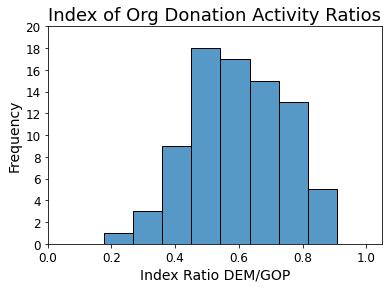

In [55]:
sns.histplot(data=company_level_df, x='ratio_index', stat='count')
plt.title('Index of Org Donation Activity Ratios', fontsize=18)
plt.xlabel('Index Ratio DEM/GOP')
plt.ylabel('Frequency')
plt.yticks(np.arange(0, 22, 2))
plt.xlim(0, 1.05)
#plt.ylim(0, 1.05)
plt.show()

In [56]:
# The ratio of donations checks out (Oil Companies --> GOP, Tech/Entertainment/Gov't Related --> Dem)
company_level_df[['common_name', 'ratio_index']].sort_values(by=['ratio_index']).head()

,common_name,ratio_index
77,VALERO,0.177109
34,EXXON MOBIL,0.291029
55,MARATHON,0.329702
24,CONOCO,0.352245
64,PHILLIPS 66,0.379084


In [57]:
company_level_df[['common_name', 'ratio_index']].sort_values(by=['ratio_index']).tail()

,common_name,ratio_index
37,FANNIE MAE,0.848614
3,AMAZON,0.878000
31,WALT DISNEY,0.893195
35,FACEBOOK,0.901505
2,GOOGLE,0.907386


In [58]:
company_level_df[['common_name', 'ratio_index']].describe()

,ratio_index
count,81.000000
mean,0.595930
std,0.148934
min,0.177109
25%,0.497898
50%,0.601969
75%,0.705029
max,0.907386


In [59]:
change_dir(PROJECT_ROOT, '/data')
df_floyd = pd.read_csv('df_final.csv')

      
New Working Directory: ~/data


In [60]:
df_floyd.head()

,tweet_id,text,replies,retweets,likes,quotes,media,source_label,username,ceo_account,...,hashtags_count,dollar_count,quest_count,exclam_count,emoji_count,text_clean,stemmed_text,postclean_length,floyd_stance,floyd_followup
0,t1271235256918487040,An important update from SusanWojcicki on how ...,85.0,187.0,1689.0,14.0,no_media,Twitter Web App,sundarpichai,1.0,...,0.0,1.0,0.0,0.0,0.0,important update susanwojcicki youtube using p...,import updat susanwojcicki youtub use platform...,247.0,0.0,1.0
1,t1270968380304941058,Proud that GoogleCloud is partnering with Tele...,71.0,416.0,1937.0,47.0,no_media,Twitter Web App,sundarpichai,1.0,...,0.0,0.0,0.0,0.0,0.0,proud googlecloud partnering telefonica launch...,proud googlecloud partner telefonica launch ne...,216.0,0.0,0.0
2,t1270957112097570816,Also excited that in Android## were making imp...,89.0,406.0,3020.0,48.0,no_media,Twitter Web App,sundarpichai,1.0,...,1.0,0.0,0.0,0.0,0.0,also excited android## making improvements voi...,also excit android## make improv voic access i...,121.0,0.0,0.0
3,t1270954939309645824,Android ## is now available in beta with a foc...,152.0,707.0,5377.0,45.0,no_media,Twitter Web App,sundarpichai,1.0,...,0.0,0.0,0.0,0.0,0.0,android ## available beta focus people control...,android ## avail beta focus peopl control safeti,79.0,0.0,0.0
4,t1267094364976672768,Today on US Google YouTube homepages we share...,1737.0,6360.0,37997.0,700.0,photo,Twitter Web App,sundarpichai,1.0,...,0.0,0.0,0.0,0.0,0.0,today us google youtube homepages share suppor...,today us googl youtub homepag share support ra...,281.0,1.0,0.0


In [61]:
df_floyd.rename({'compustat_company': 'compustat_name'}, axis=1, inplace=True)
df_floyd['sum_followups'] = df_floyd.groupby('compustat_name')['floyd_followup'].transform('sum')

df_floyd['stance_date'] = df_floyd['days_from_event'][df_floyd['floyd_stance']==1]
df_floyd['stance_date'] = df_floyd.groupby(['compustat_name'], sort=False)['stance_date'].apply(lambda x: x.ffill().bfill())
df_floyd.fillna({'stance_date': -1}, inplace=True)

In [62]:
df_floyd[['compustat_name','sum_followups']].tail()

,compustat_name,sum_followups
41527,WELLS FARGO & CO,0.0
41528,WELLS FARGO & CO,0.0
41529,WELLS FARGO & CO,0.0
41530,WELLS FARGO & CO,0.0
41531,WELLS FARGO & CO,0.0


In [63]:
df_floyd = df_floyd[['stance_date', 'sum_followups', 'compustat_name']]
df_floyd = df_floyd.groupby('compustat_name')
df_floyd = df_floyd.first()
df_floyd = df_floyd.reset_index()

In [64]:
df_floyd[['compustat_name','sum_followups']].sort_values(by=['sum_followups']).tail(10)

,compustat_name,sum_followups
23,COCA-COLA CO,4.0
48,JOHNSON & JOHNSON,4.0
71,TYSON FOODS INC -CL A,5.0
8,ANTHEM INC,5.0
21,CISCO SYSTEMS INC,6.0
40,GOLDMAN SACHS GROUP INC,9.0
57,MICROSOFT CORP,18.0
11,AT&T INC,31.0
63,PROCTER AND GAMBLE CO,42.0
50,KROGER CO,70.0


In [65]:
df_floyd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   compustat_name  80 non-null     object 
 1   stance_date     80 non-null     float64
 2   sum_followups   80 non-null     float64
dtypes: float64(2), object(1)
memory usage: 2.0+ KB


In [66]:
# Remove companies with no tweets
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 202470 entries, 0 to 202469
Data columns (total 21 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   committee_id                 202470 non-null  object 
 1   committee_name               202470 non-null  object 
 2   report_year                  202470 non-null  int64  
 3   report_type                  193247 non-null  object 
 4   contributor_name             202470 non-null  object 
 5   contributor_street_1         202388 non-null  object 
 6   contributor_employer         202470 non-null  object 
 7   contributor_occupation       202209 non-null  object 
 8   contribution_receipt_date    202468 non-null  object 
 9   contribution_receipt_amount  202470 non-null  float64
 10  contributor_aggregate_ytd    202461 non-null  float64
 11  link_id                      202470 non-null  int64  
 12  two_year_transaction_period  202470 non-null  int64  
 13 

In [67]:
df_floyd_merged = pd.merge(left=df_merged, right=df_floyd, on='compustat_name', how='left')

In [68]:
df_floyd_merged.info()
df_floyd_merged.dropna(subset=['stance_date'], inplace=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 202470 entries, 0 to 202469
Data columns (total 23 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   committee_id                 202470 non-null  object 
 1   committee_name               202470 non-null  object 
 2   report_year                  202470 non-null  int64  
 3   report_type                  193247 non-null  object 
 4   contributor_name             202470 non-null  object 
 5   contributor_street_1         202388 non-null  object 
 6   contributor_employer         202470 non-null  object 
 7   contributor_occupation       202209 non-null  object 
 8   contribution_receipt_date    202468 non-null  object 
 9   contribution_receipt_amount  202470 non-null  float64
 10  contributor_aggregate_ytd    202461 non-null  float64
 11  link_id                      202470 non-null  int64  
 12  two_year_transaction_period  202470 non-null  int64  
 13 

In [1319]:
df_floyd_one = df_floyd_merged[['stance_date', 'sum_followups', 'compustat_name', 'ratio_index']]
df_floyd_one = df_floyd_one.groupby('compustat_name')
df_floyd_one = df_floyd_one.first()
df_floyd_one = df_floyd_one.reset_index()

In [1380]:
df_floyd_one_stance = df_floyd_one[(df_floyd_one['stance_date'] > 0) & (df_floyd_one['stance_date'] < 17)]
df_floyd_one_stance.to_pickle('df_4_full.pkl', protocol=4)
#
# #### PICKLED HERE FOR SUMMARY
# 

In [1321]:
df_floyd_one_followups = df_floyd_one[df_floyd_one['stance_date'] > 0] 
df_floyd_one_followups = df_floyd_one[df_floyd_one['sum_followups'] < 15] 
df_floyd_one_followups2 = df_floyd_one[(df_floyd_one['sum_followups'] > 0) & (df_floyd_one['sum_followups'] < 15)]

df_floyd_one.tail(10)

,compustat_name,stance_date,sum_followups,ratio_index
69,TJX COS INC (THE),-1.0,0.0,0.753975
70,TYSON FOODS INC -CL A,14.0,5.0,0.566788
71,UNITED AIRLINES HOLDINGS INC,9.0,0.0,0.648908
72,UNITED PARCEL SERVICE INC,14.0,1.0,0.424565
73,UNITEDHEALTH GROUP INC,8.0,0.0,0.783187
74,VALERO ENERGY CORP,-1.0,0.0,0.175374
75,VERIZON COMMUNICATIONS INC,7.0,2.0,0.628901
76,WALGREENS BOOTS ALLIANCE INC,6.0,1.0,0.560002
77,WALMART INC,4.0,3.0,0.500717
78,WELLS FARGO & CO,8.0,0.0,0.525568


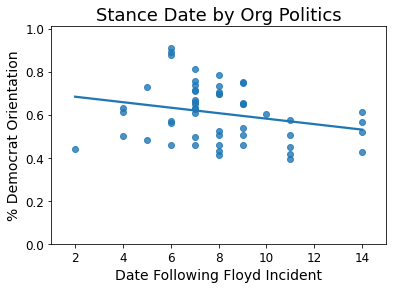

In [1352]:
# Among those who took stance, removing federal gov't entities (Fannie Mae, Freddie Mac)
sns.regplot(data=df_floyd_one_stance, x='stance_date', y='ratio_index', ci=None)
plt.title('Stance Date by Org Politics', fontsize=18)
plt.xlabel('Date Following Floyd Incident')
plt.ylabel('% Democrat Orientation')
#plt.yticks(np.arange(0, 1.1, 0.2))
plt.xlim(1, 15)
plt.ylim(0.0, 1.01)
plt.show()

In [1383]:
corr_df = df_floyd_one_stance[['stance_date','ratio_index']]
corr_df.corr()

,stance_date,ratio_index
stance_date,1.000000,-0.246134
ratio_index,-0.246134,1.000000


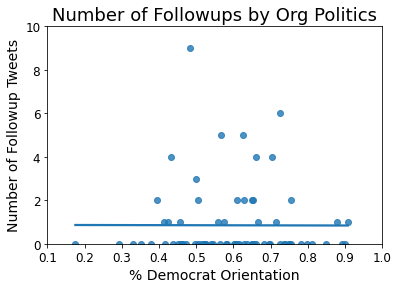

In [1381]:
# Among those who took a stance, limit to those with fewer than 15 followups (those with more were indiv responses)
sns.regplot(data=df_floyd_one_followups, x='ratio_index', y='sum_followups', ci=None)
plt.title('Number of Followups by Org Politics', fontsize=18)
plt.xlabel('% Democrat Orientation')
plt.ylabel('Number of Followup Tweets')
#plt.yticks(np.arange(0, 1.1, 0.2))
plt.xlim(0.1, 1)
plt.ylim(0, 10)
plt.show()

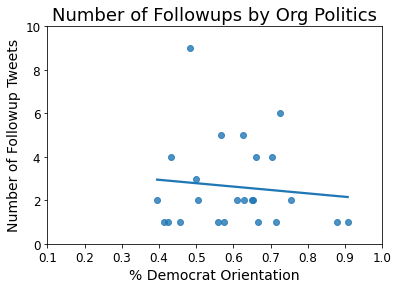

In [1382]:
# Among those who followed up
sns.regplot(data=df_floyd_one_followups2, x='ratio_index', y='sum_followups', ci=None)
plt.title('Number of Followups by Org Politics', fontsize=18)
plt.xlabel('% Democrat Orientation')
plt.ylabel('Number of Followup Tweets')
#plt.yticks(np.arange(0, 1.1, 0.2))
plt.xlim(0.1, 1)
plt.ylim(0, 10)
plt.show()